In [1]:
import pandas as pd
import numpy as np
import h5py    
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Chargement des données

In [2]:
path = './data'
dg_data = h5py.File(f'{path}/DG10_dataset.h5', 'r+')   
sg_data = h5py.File(f'{path}/SG24_dataset.h5', 'r+')

In [3]:
dataX_SG=np.array(sg_data['Predictors']).T
dataY_SG=np.array(sg_data['Target']).T
dataU_SG=np.array(sg_data['User']).T

In [4]:
dg_data.close()
sg_data.close()

### Statistiques globales

In [5]:
pd.DataFrame(dataX_SG).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,53.669293,-5.698329,0.203902,0.491011,-0.140472,0.164828,-0.149610,129.851667,137.503750,145.390833,...,110.054167,82.854167,103.005417,91.606667,143.834167,109.237083,120.668750,82.562500,137.099167,83.047500
std,41.520634,32.720964,22.393903,0.249192,0.281654,0.690302,0.268272,32.298842,15.895186,31.776834,...,46.031646,20.323427,45.260604,22.685341,53.253552,17.291823,29.802893,48.056139,21.926745,30.394479
min,0.000000,-81.559349,-68.739662,0.000000,-0.855817,-1.000000,-0.789427,1.000000,44.000000,36.000000,...,0.000000,1.000000,1.000000,25.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,-26.450032,-15.801244,0.314152,-0.387735,-0.846747,-0.360048,122.000000,128.000000,121.750000,...,63.000000,71.000000,79.000000,75.000000,92.000000,105.000000,104.000000,49.000000,131.000000,64.000000
50%,70.621365,0.000000,0.000000,0.555695,0.000000,0.471377,-0.062433,128.000000,135.000000,152.000000,...,132.000000,81.000000,114.000000,92.000000,159.000000,106.000000,126.000000,86.000000,141.000000,78.000000
75%,84.528341,0.000000,17.166466,0.691598,0.000000,0.629917,0.000000,134.000000,143.000000,170.000000,...,151.000000,93.000000,134.000000,111.000000,192.000000,107.000000,142.000000,116.000000,149.000000,101.000000
max,127.721718,78.185921,59.903419,0.955188,0.727471,1.000000,0.782390,238.000000,206.000000,207.000000,...,179.000000,170.000000,218.000000,229.000000,248.000000,255.000000,189.000000,216.000000,192.000000,193.000000


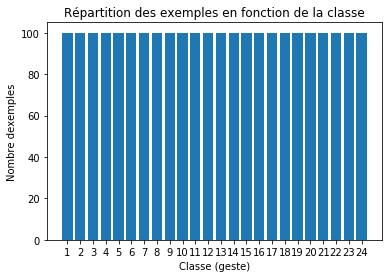

In [7]:
targets,counts=np.unique(dataY_SG,return_counts=True)
plt.bar(targets,counts)
plt.xlabel('Classe (geste)')
plt.xticks(targets)
#plt.yticks(counts)
plt.ylabel('Nombre d''exemples')
plt.title("Répartition des exemples en fonction de la classe")
plt.show()

### Répartition des exemples selon les utilisateurs

In [9]:
targets,counts=np.unique(dataU_SG,return_counts=True)

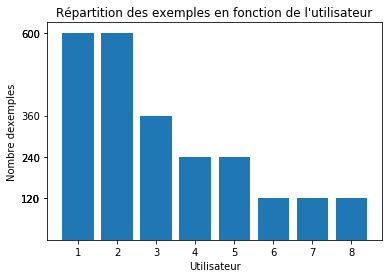

In [10]:
plt.bar(targets,counts)
plt.xlabel('Utilisateur')
plt.xticks(targets)
plt.yticks(counts)
plt.ylabel('Nombre d''exemples')
plt.title("Répartition des exemples en fonction de l'utilisateur")
plt.show()

### Nombre d'exemple par geste (catégorie) et par utilisateur

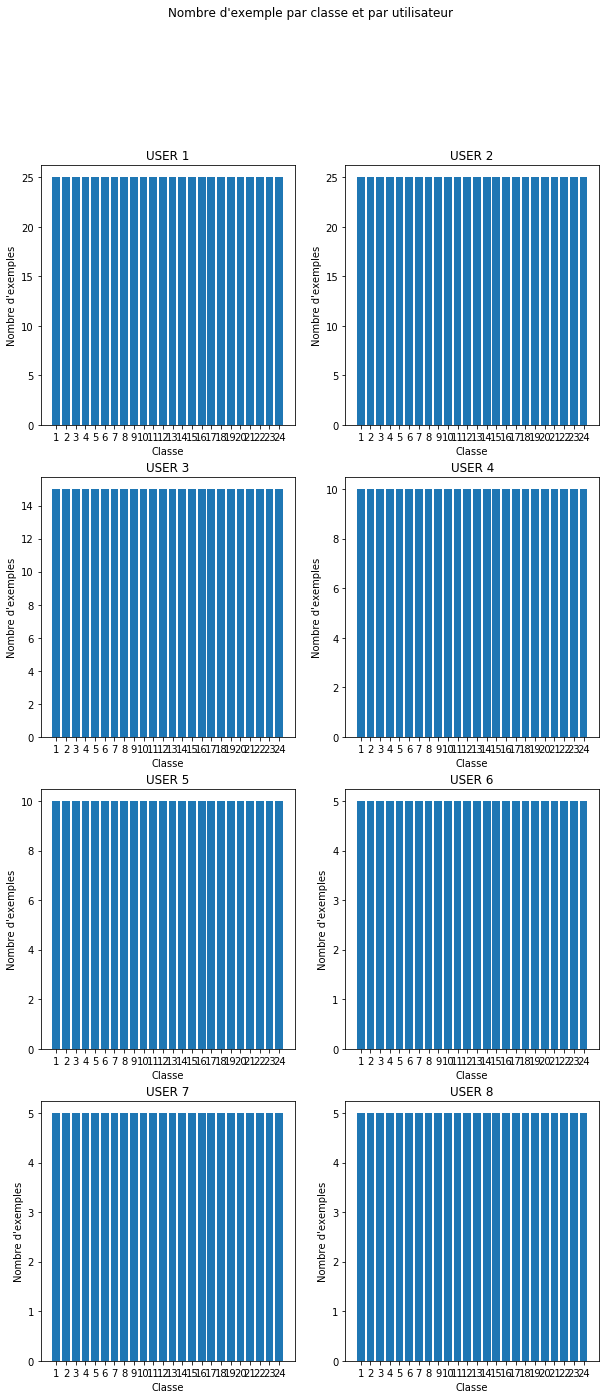

In [19]:
fig,ax=plt.subplots(4,2,figsize=(10,22))
u=1
for i in range(4):
    for j in range(2):
        targets,counts=np.unique(dataY_SG[np.where(dataU_SG==u)[0]],return_counts=True)
        ax[i,j].bar(targets,counts)
        ax[i,j].set_title("USER "+str(u))
        ax[i,j].set_xticks(targets)
        ax[i,j].set_xlabel("Classe")
        ax[i,j].set_ylabel("Nombre d'exemples")
        #ax[i,j].set_yticks(counts)
        u+=1
fig.suptitle("Nombre d'exemple par classe et par utilisateur")
plt.show()

### Distribution de probabilité des attributs selon l'utilisateur 

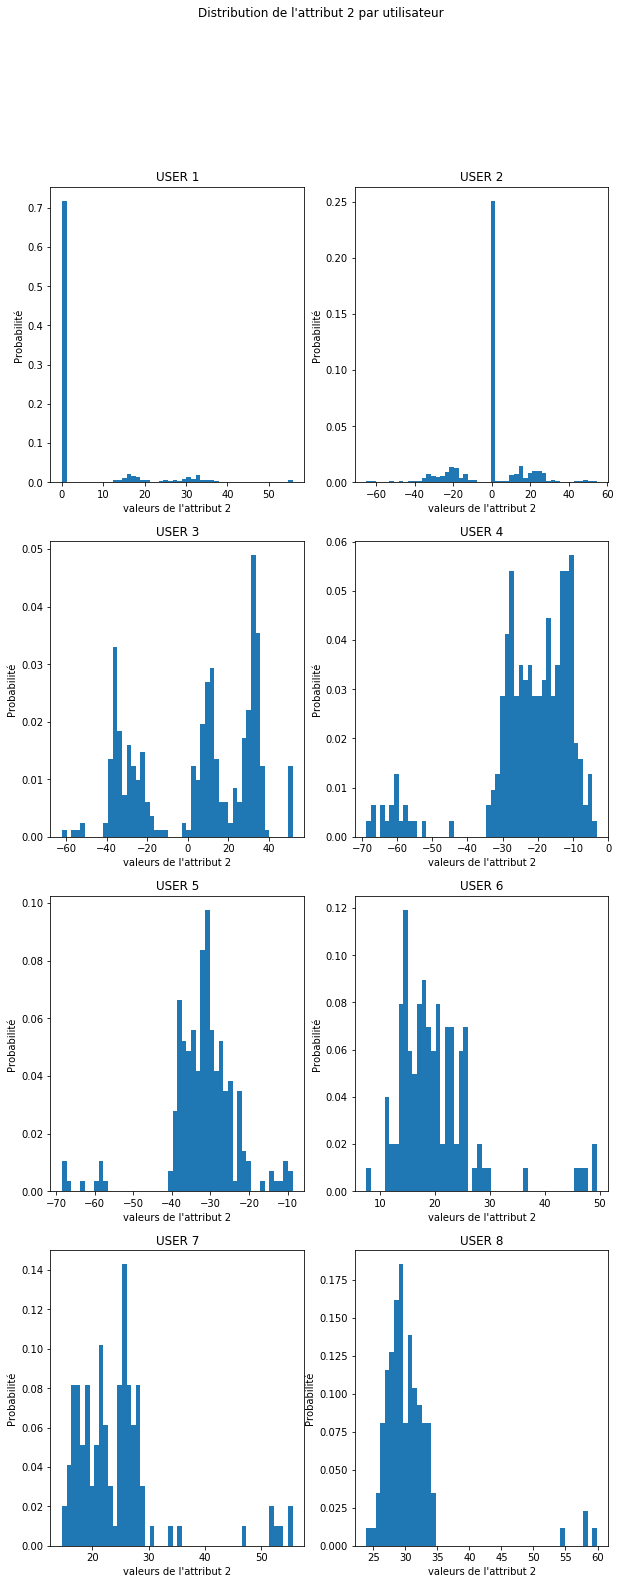

In [23]:
fig,ax=plt.subplots(4,2,figsize=(10,25))
u=1
attribut=2
for i in range(4):
    for j in range(2):
        ax[i,j].hist(dataX_SG[np.where(dataU_SG==u)[0],attribut],bins=50,density=True)
        ax[i,j].set_title("USER "+str(u))
        ax[i,j].set_xlabel("valeurs de l'attribut "+str(attribut))
        ax[i,j].set_ylabel("Probabilité")
        u+=1
fig.suptitle("Distribution de l'attribut "+str(attribut)+" par utilisateur")
plt.show()

### Split en train et test

In [25]:
X_train,X_test,Y_train,Y_test=np.ones((1,29)),np.ones((1,29)),np.ones((1,1)),np.ones((1,1))
for i in np.unique(dataU_SG):
    x=dataX_SG[np.where(dataU_SG==i)[0],:]
    y=dataY_SG[np.where(dataU_SG==i)[0]]
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=100)
    X_train=np.append(X_train,x_train,axis=0)
    X_test=np.append(X_test,x_test,axis=0)
    Y_train=np.append(Y_train,y_train,axis=0)
    Y_test=np.append(Y_test,y_test,axis=0)
X_train,X_test,Y_train,Y_test=X_train[1:],X_test[1:],Y_train[1:],Y_test[1:]


### Répartition des examples en fonction da la classe et du user dans le train set

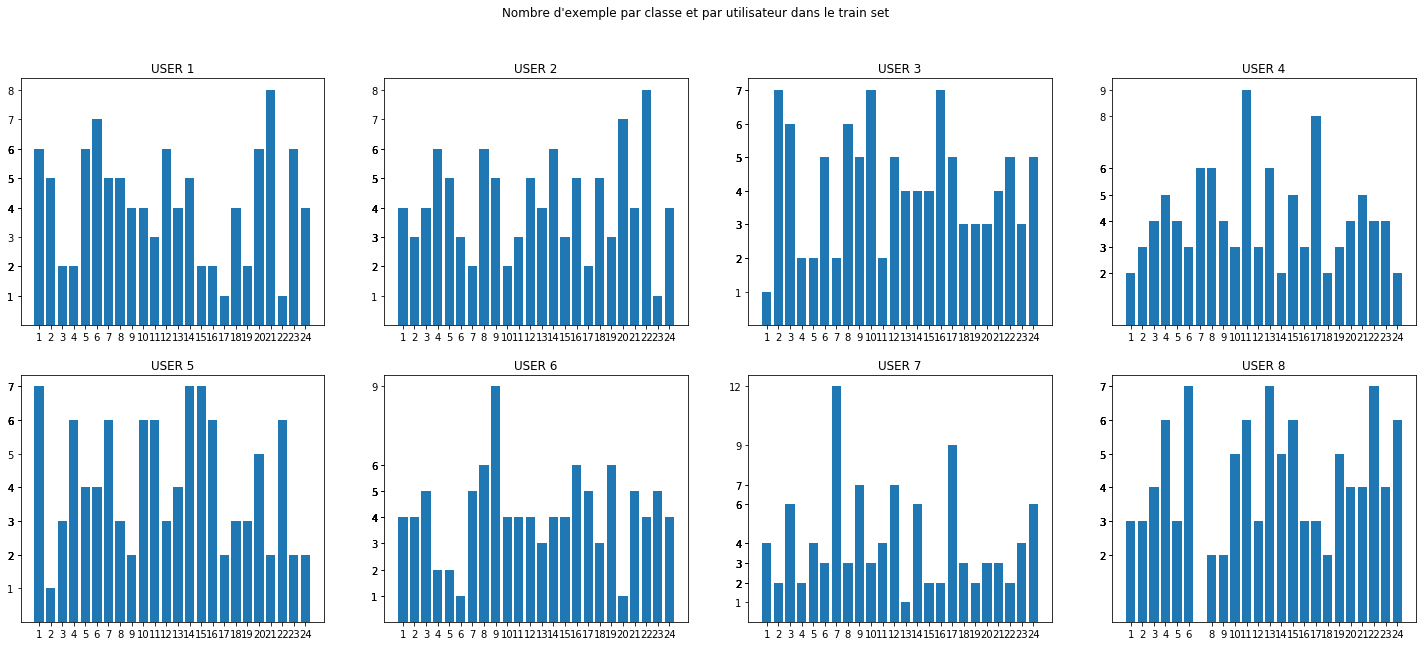

In [113]:
fig,ax=plt.subplots(2,4,figsize=(25,10))
u=1
for i in range(2):
    for j in range(4):
        targets,counts=np.unique(Y_train[(u-1)*100:u*100],return_counts=True)
        ax[i,j].bar(targets,counts)
        ax[i,j].set_title("USER "+str(u))
        ax[i,j].set_xticks(targets)
        ax[i,j].set_yticks(counts)
        u+=1
fig.suptitle("Nombre d'exemple par classe et par utilisateur dans le train set")
plt.show()

In [26]:
X_train,Y_train=shuffle(X_train,Y_train,random_state=0)
X_test,Y_test=shuffle(X_test,Y_test,random_state=0)

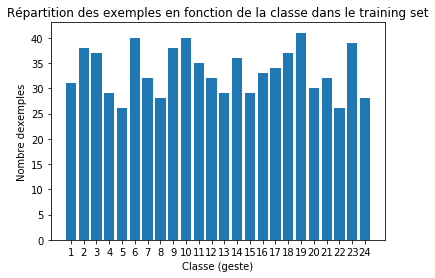

In [27]:
targets,counts=np.unique(Y_train,return_counts=True)
plt.bar(targets,counts)
plt.xlabel('Classe (geste)')
plt.xticks(targets)
#plt.yticks(counts)
plt.ylabel('Nombre d''exemples')
plt.title("Répartition des exemples en fonction de la classe dans le training set")
plt.show()

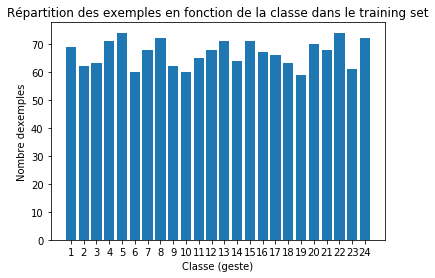

In [28]:
targets,counts=np.unique(Y_test,return_counts=True)
plt.bar(targets,counts)
plt.xlabel('Classe (geste)')
plt.xticks(targets)
#plt.yticks(counts)
plt.ylabel('Nombre d''exemples')
plt.title("Répartition des exemples en fonction de la classe dans le training set")
plt.show()